## 04: Service Area Analysis - Buffers vs. Isochrones

**Goal:** To understand and compare two fundamental methods for defining service or catchment areas around points of interest:

1.  **Geometric Buffers:** Simple circles drawn around a point representing a fixed straight-line ("as the crow flies") distance. Fast and easy, but often unrealistic in urban environments.
2.  **Isochrones/Isodistances:** Service areas based on a real street network. They represent all the locations reachable within a specified travel time or distance. These are far more realistic for accessibility analysis.

We will use libraries in Exeter as our points of interest and analyze their service areas.

### 1. Setup and Library Imports

In [2]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as cx

# Configure osmnx
ox.settings.log_console = True
ox.settings.use_cache = True

### 2. Define Points of Interest (Exeter Libraries)

We'll manually define the locations of a few libraries in Exeter. In a real project, you might geocode these from a list of addresses.

In [3]:
# Data for Exeter Libraries (Name, Longitude, Latitude)
libraries_data = {
    'Exeter Library': [-3.5246, 50.7247],
    'St Thomas Library': [-3.5425, 50.7169],
    'Pinhoe Library': [-3.4752, 50.7408]
}

# Create a GeoDataFrame
df = pd.DataFrame.from_dict(libraries_data, orient='index', columns=['longitude', 'latitude'])
libraries_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326" # Standard WGS84 lat/lon
)

print("Libraries GeoDataFrame:")
libraries_gdf

Libraries GeoDataFrame:


,longitude,latitude,geometry
Exeter Library,-3.5246,50.7247,POINT (-3.5246 50.7247)
St Thomas Library,-3.5425,50.7169,POINT (-3.5425 50.7169)
Pinhoe Library,-3.4752,50.7408,POINT (-3.4752 50.7408)


### 3. Method 1: Geometric Buffers

First, we'll create simple circular buffers. It's crucial to project our data into a suitable projected coordinate system (like UTM) where units are in meters, so our buffer distance is meaningful.

In [4]:
# Project to a local CRS (UTM Zone 30N for Exeter) to work in meters
libraries_proj = libraries_gdf.to_crs(epsg=32630)

# Create a 1500-meter (1.5km) buffer around each library
buffers_gdf = libraries_proj.copy()
buffers_gdf['geometry'] = libraries_proj.geometry.buffer(1500)

print("Buffers GeoDataFrame created.")

Buffers GeoDataFrame created.


### 4. Method 2: Network-based Isochrones

Now for the more advanced method. We'll download the Exeter street network for walking and calculate a 15-minute travel time area from each library.

In [8]:

# Define the place and get the street network
place_name = "Exeter, England"
G = ox.graph_from_place(place_name, network_type='walk')

# Get the nearest network node for each library
library_nodes = ox.nearest_nodes(G, X=libraries_gdf.geometry.x, Y=libraries_gdf.geometry.y)

# Calculate isochrones for a 15-minute walk
# Assumes an average walking speed of 4.5 km/hour
travel_time_minutes = 15
meters_per_minute = 4500 / 60  # 4.5 km/hr walking speed
travel_distance_meters = travel_time_minutes * meters_per_minute

isochrones = []
for node in library_nodes:
    # Create a subgraph around each library
    subgraph = ox.truncate.truncate_graph_dist(G, node, dist=travel_distance_meters)
    
    # Get the convex hull of the node geometries in the subgraph
    nodes_gdf = ox.graph_to_gdfs(subgraph, edges=False)
    hull = nodes_gdf.geometry.union_all().convex_hull
    isochrones.append(hull)

# Create a GeoDataFrame for the isochrones
isochrones_gdf = gpd.GeoDataFrame(
    {'name': libraries_gdf.index},
    geometry=isochrones,
    crs=G.graph['crs']
)

print("Isochrones GeoDataFrame created.")


Isochrones GeoDataFrame created.


### 5. Compare the Results Visually

Plotting both the buffers and the isochrones on the same map highlights the significant difference. The isochrones are shaped by the actual street layout, river crossings, and path availability.

/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_21274/2392935834.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


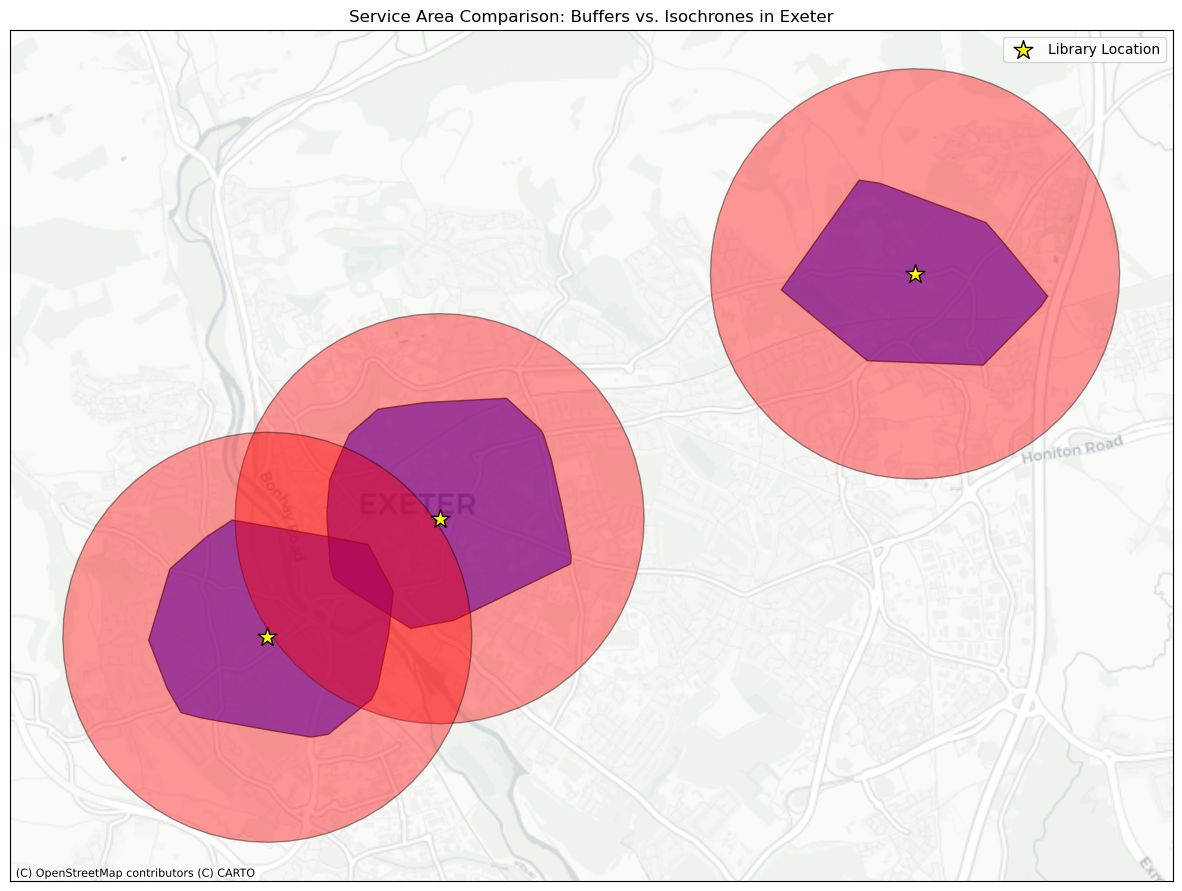

In [9]:
# We need all layers in the same CRS for plotting. Let's use Web Mercator (EPSG:3857).
buffers_plot = buffers_gdf.to_crs(epsg=3857)
isochrones_plot = isochrones_gdf.to_crs(epsg=3857)
libraries_plot = libraries_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 15))

# Plot the isochrones (network-based)
isochrones_plot.plot(ax=ax, color='blue', edgecolor='black', alpha=0.6, label='15-Min Walk Isochrone')

# Plot the buffers (simple distance)
buffers_plot.plot(ax=ax, color='red', edgecolor='black', alpha=0.4, label='1.5 km Buffer')

# Plot the libraries
libraries_plot.plot(ax=ax, marker='*', color='yellow', markersize=200, edgecolor='black', label='Library Location')

ax.set_title('Service Area Comparison: Buffers vs. Isochrones in Exeter')
ax.set_xticks([])
ax.set_yticks([])
ax.legend()

# Add a basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

plt.show()

# Discussion:
# - The red circles (buffers) are uniform and don't respect any real-world features like the River Exe.
# - The blue polygons (isochrones) are irregular. They stretch along major roads and are constrained by features like the river, only crossing at bridge points. This provides a much more accurate picture of what is truly accessible from each library on foot.
# - This demonstrates why for any serious accessibility or location-based analysis in an urban area, network-based methods are essential.